In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('..')
from utils.input_pipeline import get_image_folders
from utils.training import train, optimization_step
from utils.diagnostic import count_params
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 128

In [5]:
train_folder, val_folder = get_image_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

In [6]:
# number of validation samples
val_size = len(val_folder.imgs)
val_size

10000

# Model

In [7]:
from get_densenet import get_model

In [8]:
model, loss, optimizer = get_model()

In [9]:
# number of params in the model
count_params(model)

440264

# Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 200
n_batches = ceil(train_size/batch_size)

lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=4, 
    verbose=True, threshold=0.01, threshold_mode='abs'
)

# total number of batches in the train set
n_batches

782

In [11]:
%%time
def optimization_step_fn(model, loss, x_batch, y_batch):
    return optimization_step(model, loss, x_batch, y_batch, optimizer)

all_losses = train(
    model, loss, optimization_step_fn,
    train_iterator, val_iterator, n_epochs,
    patience=9, threshold=0.01,  # for early stopping
    lr_scheduler=lr_scheduler
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  4.623 4.219  0.064 0.113  0.195 0.304  228.915
1  4.078 3.956  0.125 0.156  0.328 0.374  226.131
2  3.802 3.467  0.165 0.217  0.397 0.480  226.623
3  3.614 3.394  0.194 0.228  0.441 0.487  226.667
4  3.476 3.223  0.217 0.252  0.473 0.524  226.629
5  3.365 3.118  0.238 0.284  0.499 0.557  226.626
6  3.280 3.092  0.254 0.290  0.516 0.568  226.645
7  3.220 3.040  0.263 0.291  0.533 0.572  226.711
8  3.161 3.067  0.274 0.293  0.545 0.566  226.695
9  3.111 2.942  0.282 0.317  0.557 0.600  226.587
10  3.073 2.883  0.289 0.332  0.564 0.618  226.699
11  3.046 2.810  0.294 0.341  0.571 0.629  226.718
12  3.016 2.951  0.300 0.321  0.578 0.605  226.733
13  2.980 2.919  0.307 0.327  0.585 0.611  226.702
14  2.960 2.757  0.310 0.356  0.588 0.637  226.604
15  2.937 2.965  0.316 0.323  0.593 0.611  226.718
16  2.924 2.780  0.319 0.348  0.595 0.633  226.685
17  2.908 2.835  0.321 0.343  0.600 0.623  226.650
18  2.889 2.712  0.327 0.369  0.605 0.646  226.662
19  2.870 2.662  0.328 0.373  0.608 0.660

# Loss/epoch plots

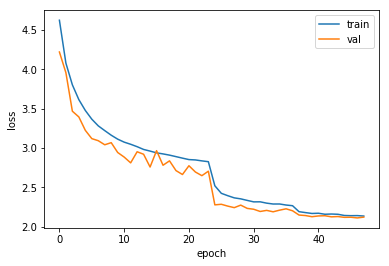

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

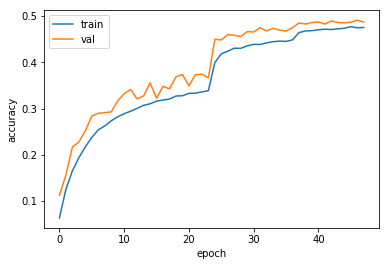

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

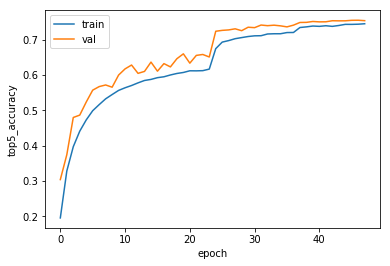

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [15]:
model.cpu();
torch.save(model.state_dict(), 'model.pytorch_state')